# Datenbeschaffung und -reinigung

In [15]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model

In [16]:
dataset_path = 'Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

In [17]:

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

# Display the first few rows of the DataFrame
print(df.head())

                                            image    label
0      Rice_Image_Dataset\Arborio\Arborio (1).jpg  Arborio
1     Rice_Image_Dataset\Arborio\Arborio (10).jpg  Arborio
2    Rice_Image_Dataset\Arborio\Arborio (100).jpg  Arborio
3   Rice_Image_Dataset\Arborio\Arborio (1000).jpg  Arborio
4  Rice_Image_Dataset\Arborio\Arborio (10000).jpg  Arborio


# Explorative Datenanalyse (EDA)

## Analyse der Datenstrukturen

In [18]:
# Basic statistics about the dataset
print(df['label'].value_counts())

label
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64


## Erkennung von Mustern und Beziehungen

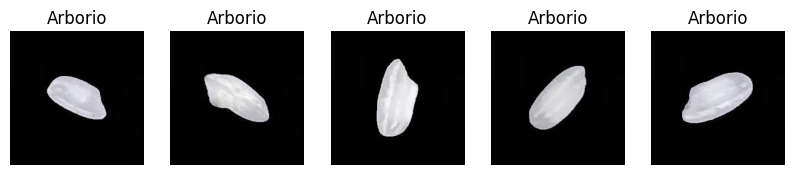

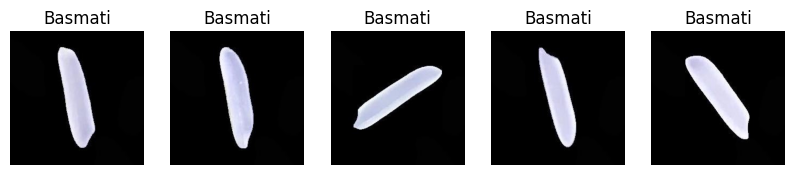

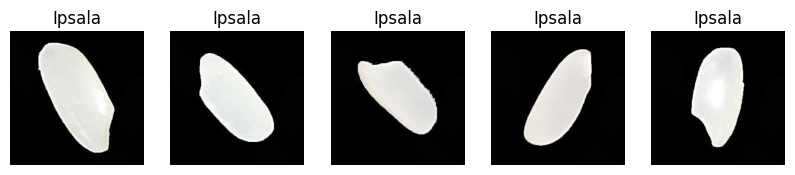

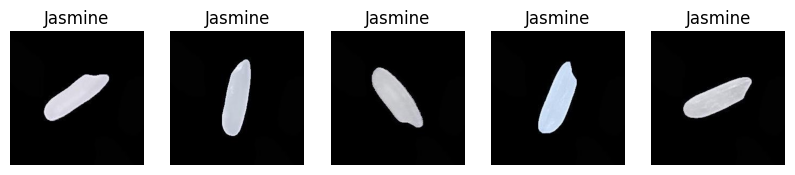

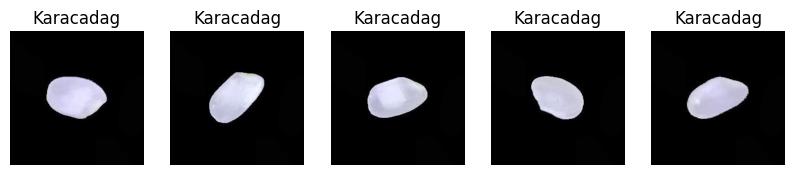

In [19]:
# Display a few example images from each class
for label in df['label'].unique():
    plt.figure(figsize=(10, 10))
    sample_images = df[df['label'] == label].sample(5)
    for i, image_path in enumerate(sample_images['image']):
        img = Image.open(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()


## Vorverarbeitung der Daten

### Erkennen von Anomalien und Ausreißern

In [20]:
# Example code to check for corrupted images
for image_path in df['image']:
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {image_path}")



### Testen von Annahmen, Auswahl und Entwicklung von Merkmalen, Optimierung des Modellentwurfs, Erleichterung der Datenbereinigung, Verbesserung der Kommunikation

In [21]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


# Datenaufteilung und Modelltraining

In [22]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,  # Less augmentation to speed up training
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create training and validation generators
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(64, 64),  # Smaller image size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(64, 64),  # Smaller image size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Smaller input size
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # Reduced dense layer size
    Dense(len(train_df['label'].unique()), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Fewer epochs
)


Found 48000 validated image filenames belonging to 5 classes.
Found 12000 validated image filenames belonging to 5 classes.
Epoch 1/10


c:\Users\vae.tiolamon\Documents\DHBW 4. Semester\Machine Learning Fundamentals\MLsem4\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\vae.tiolamon\Documents\DHBW 4. Semester\Machine Learning Fundamentals\MLsem4\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 136s 90ms/step - accuracy: 0.8627 - loss: 0.3543 - val_accuracy: 0.9747 - val_loss: 0.0731
Epoch 2/10


C:\Users\vae.tiolamon\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


AttributeError: 'NoneType' object has no attribute 'items'

# Modellbewertung

In [ ]:
# Evaluate the model on the test data
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(64, 64),  # Consistent image size
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model
loss, cnn_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {cnn_accuracy}")



# Modellvergleich

### Entscheidungsbaum-Modell

In [ ]:
def load_and_flatten_image(image_path):
    img = Image.open(image_path).resize((64, 64))  # Consistent size
    img_array = np.array(img).flatten()
    return img_array

# Load and flatten images
train_images = np.array([load_and_flatten_image(img_path) for img_path in train_df['image']])
test_images = np.array([load_and_flatten_image(img_path) for img_path in test_df['image']])

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_df['label'])
test_labels = le.transform(test_df['label'])

# Train Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(train_images, train_labels)

# Predict and evaluate
dt_predictions = dt_model.predict(test_images)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")

### Vergleich der Modelle

In [ ]:
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"CNN Accuracy: {cnn_accuracy}")

# Implementierung und Einsatz

In [ ]:
# Speichern des Modells
model.save('rice_cnn_model.h5')

# Laden des Modells für den Einsatz
loaded_model = load_model('rice_cnn_model.h5')

# Vorhersage für neue Bilder
def preprocess_image(image_path):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img) / 255.0  # Rescale
    return img_array

def predict_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = loaded_model.predict(img)
    return np.argmax(prediction)

# Beispielvorhersage
sample_image_path = 'path_to_sample_image.jpg'  # Replace with an actual image path
predicted_class = predict_image(sample_image_path)
print(f'Predicted class: {predicted_class}')